Apply LDA to classify spectral embeddings:
    
    Tools: scikit-learn 0.24.1


##  LDA

In [1]:
import os
from matplotlib import pyplot as plt
import pickle
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
import pandas as pd

## Define functions

In [15]:
def define_data(X_embedding, y_label_list, min_group_size=1, remove_unclassified = True):
    y_label = np.array(y_label_list)
    # Kick out the unexpected groups     
    lbs = Counter(y_label)
    lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
    sel_index=[]
    for i,v in enumerate(list(lbs.values())):
        if v >= min_group_size:
            sel_index.append(i)
    select_lbs = [list(lbs.keys())[i] for i in sel_index]   
    if remove_unclassified == True:
        if 'Unclassified' in select_lbs:
            select_lbs.remove('Unclassified')           
    print(str(len(select_lbs))+' groups were selected.')    
    # Connect the selected groups to embeddings
    select_index = []
    for i in select_lbs:
        temp_index, = np.where(y_label==i)
        #print(temp_index)
        select_index += list(temp_index)
    select_index.sort()
    #print(select_index)
    y_label_2 = np.array(y_label[select_index])
    print(y_label_2.shape)
    X_embedding_2=X_embedding[select_index,:]
    print(X_embedding_2.shape)
    print(f'Selecting {len(select_index)} of {len(y_label_list)} spectra.')
    return X_embedding_2, y_label_2


def perform_lda(X_embedding, y_label, testing_size = 0.25, stratification=True):
    # Split the dataset into the Training set and Test set
    if stratification == True:
        X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = testing_size, random_state = 0, stratify=y_label)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_embedding, y_label, test_size = testing_size, random_state = 0)
        
    # Apply Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
#     with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/x_test_lda.pkl','wb') as f:
#         pickle.dump(X_test, f)
#     with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_test_lda.pkl','wb') as f:
#         pickle.dump(y_test, f)

    # Apply LDA
    t0=time.process_time()
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train,y_train)
    t1=time.process_time()-t0
    print('Time elapsed: %.3f' % t1)

    # Predict the test set results and check the accuracy
    y_pred = lda_model.predict(X_test)
    accuracy_lda = accuracy_score(y_test,y_pred)
    print('Accuracy: %.3f' % accuracy_lda)

    labels =list(np.unique(np.array(list(y_test)+list(y_pred))))
    conf_mat = confusion_matrix(y_test,y_pred, labels = labels)
    print(conf_mat)
    return conf_mat,y_test,y_train,y_pred,labels


def plot_confusion_matrix(confusion_mat, labels, save_path, heatmap=False):    
    # Plot Confusion matrix  # Ignore: this plot is too large to plot.
    if len(labels) >= 10:
        a = len(labels)//5+5;
    else:
        a = 5
    
    df_cm = pd.DataFrame(confusion_mat, columns=np.unique(labels), index = np.unique(labels))
    df_cm.to_pickle(save_path+'.pkl')
    if heatmap==True:
        plt.figure(figsize = (a,a*4//5))
        ax= plt.subplot()
        df_cm.index.name = 'Actual labels'
        df_cm.columns.name = 'Predicted labels'
        sns.set(font_scale=1.8)
        sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})
        plt.savefig(save_path+'.svg',dpi=300,bbox_inches='tight')
    return df_cm
  
    
def calculate_accuracy_per_label(label, conf_matrix, y_train, save_path):
    accuracy = []
    group_size_pred=[]
    group_size_test=[]
    group_size_train=[]
    group_size = []
    predict_vs_test_size=[]
    group_size_train_dict = {k:list(y_train).count(k) for k in label}
    for i in range(len(label)):
        if label[i] != 'Unclassified':
            true_result = conf_matrix[i,i]
            all_result_pred = np.sum(conf_matrix,axis=0)[i]
            group_size_pred.append(all_result_pred)
            all_result_test = np.sum(conf_matrix,axis=1)[i]
            #print(all_result_pred, all_result_test)
            group_size_test.append(all_result_test)
            group_size_train.append(group_size_train_dict[label[i]])
            group_size.append(all_result_test+group_size_train_dict[label[i]])

            if all_result_pred == 0:
                accuracy.append(0)
            else:
                accuracy.append(true_result/all_result_pred)

            if all_result_test == 0:
                predict_vs_test_size.append(all_result_pred+1)
            else:
                predict_vs_test_size.append(all_result_pred/all_result_test)
    if 'Unclassified' in label:
        print('Removing Unclassified groups')
        label.remove('Unclassified')
    accuracy_dict = {'labels':label, 'accuracy':accuracy,'predict_vs_test_size': predict_vs_test_size,'group_size': group_size,
                     'group_size_pred':group_size_pred, 'group_size_test':group_size_test, 'group_size_train':group_size_train}
    with open(save_path, 'wb') as f:
        pickle.dump(accuracy_dict, f)
    return accuracy_dict


def scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x, x_label, datatype, save_dir):
    x= accuracy_dict[x_label]
    y= accuracy_dict['accuracy']
    plt.rcParams.update({'figure.figsize':(10,7)})
    plt.scatter(x, y)

    plt.title('Accuracy of predicted results vs. %s in %s' % (x_label, datatype))
    plt.xlabel(x_label)
    plt.ylabel('Accuracy per group')
    for i,txt in enumerate(accuracy_dict['labels']):
        if x[i] >= show_annot_min_x:
            plt.annotate(txt,(x[i],y[i]), fontsize=10)
    plt.savefig(save_dir,dpi = 100, bbox_inches='tight')
    plt.show()
    

    

In [16]:
def define_data_give_indices(X_embedding, y_label_list, min_group_size=1, remove_unclassified = True):
    
    y_label = np.array(y_label_list)
    # Kick out the unexpected groups     
    lbs = Counter(y_label)
    lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
    sel_index=[]
    for i,v in enumerate(list(lbs.values())):
        if v >= min_group_size:
            sel_index.append(i)
    select_lbs = [list(lbs.keys())[i] for i in sel_index]
    
    if remove_unclassified == True:
        if 'Unclassified' in select_lbs:
            select_lbs.remove('Unclassified')           
    print(str(len(select_lbs))+' groups were selected.')    
    # Connect the selected groups to embeddings
    select_index = []
    for i in select_lbs:
        temp_index, = np.where(y_label==i)
        #print(temp_index)
        select_index += list(temp_index)
    select_index.sort()
    #print(select_index)
    y_label_2 = np.array(y_label[select_index])
    print(y_label_2.shape)
    X_embedding_2=X_embedding[select_index,:]
    print(X_embedding_2.shape)
    print(f'Selecting {len(select_index)} of {len(y_label_list)} spectra.')
    return X_embedding_2, y_label_2,select_index

## Loading array from files

In [17]:
## Loading embedding arrays
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv') as file_name:
    X_embedding = np.loadtxt(file_name, delimiter=",")
print(X_embedding.shape)

(16360, 300)


## LDA for ClassyFire all data

### Class level in ClassyFire

(16360,)
183 groups were selected.
(15034,)
(15034, 300)
Selecting 15034 of 16360 spectra.
Time elapsed: 26.353
Accuracy: 0.351
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]


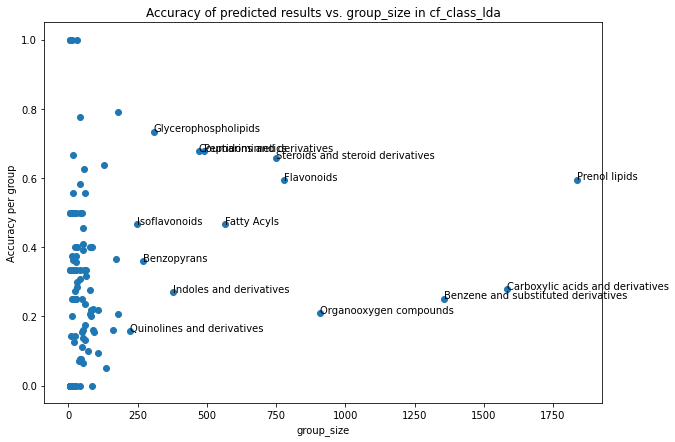

In [5]:
## Loading class labels
data_type='cf_class_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_class_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels= perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

In [7]:
## Loading class labels
data_type='cf_class_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_class_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)


(16360,)
183 groups were selected.
(15034,)
(15034, 300)
Selecting 15034 of 16360 spectra.


In [9]:
y_label_2.shape

(15034,)

In [13]:

# evaluate a decision tree for each depth
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2, y_label_2, test_size = 0.25, random_state = 0, stratify=y_label_2)
# Apply Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Apply LDA
t0=time.process_time()
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train,y_train)
t1=time.process_time()-t0
print('Time elapsed: %.3f' % t1)

# Predict the test set results and check the accuracy
y_pred = lda_model.predict(X_test)
train_yhat = lda_model.predict(X_train)
train_accuracy = accuracy_score(y_train,train_yhat)
accuracy_lda = accuracy_score(y_test,y_pred)
print('Accuracy: %.3f' % accuracy_lda)
print(train_accuracy)


Time elapsed: 3.085
Accuracy: 0.351
0.4875388026607539


In [6]:
# Find the indices of test and training sets
data_type='cf_class_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_class_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)
X_embedding_2, y_label_2,select_index = define_data_give_indices(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
indices = range(15034)
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(X_embedding_2, y_label_2,indices, test_size = 0.25, random_state = 0, stratify=y_label_2)
conf_mat,y_test,y_train,y_pred,labels= perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)


(16360,)
183 groups were selected.
(15034,)
(15034, 300)
Selecting 15034 of 16360 spectra.
Time elapsed: 2.785
Accuracy: 0.351
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]


In [7]:
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/mass_da_ui.pickle', 'rb') as file_name:
    mass_list = pickle.load(file_name)
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/inchi_list_ui.pickle', 'rb') as file_name:
    inchi_list = pickle.load(file_name)

In [8]:
mass_selected = [mass_list[i] for i in select_index]
inchi_selected = [inchi_list[i] for i in select_index]
mass_test = [mass_selected[i] for i in indices_test]
inchi_test = [inchi_selected[i] for i in indices_test]

In [18]:
# glycerolipids
glycero_indices = [i for i, x in enumerate(y_test) if x == "Glycerolipids"]
select_y_pred = [y_pred[i] for i in glycero_indices]
mass_selected_glycero_test = [mass_test[i] for i in glycero_indices]
inchi_selected_glycero_test= [inchi_test[i] for i in glycero_indices]
#print(select_y_pred)
print(len(inchi_selected_glycero_test))
#print(inchi_selected_compound_test)
print(mass_selected_glycero_test)

# Save mass dalton information
with open('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/Glycerolipids_test_inchikey.pickle','wb') as f:
    pickle.dump(inchi_selected_glycero_test,f)
with open('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/Glycerolipids_test_mass.pickle','wb') as f:
    pickle.dump(mass_selected_glycero_test,f)

45
[720.566177, 934.798177, 918.687177, 676.577177, 806.732724, 872.7961770000001, 860.702177, 726.593177, 894.7811770000001, 880.6711770000001, 850.718177, 820.6711770000001, 330.276724, 806.655177, 652.520177, 704.6081770000001, 626.504177, 878.6661770000001, 546.441177, 770.5837819999999, 718.566177, 930.687177, 288.191289, 274.214289, 860.766177, 548.457177, 734.510177, 938.749177, 628.520177, 854.749177, 852.6661770000001, 828.721177, 886.766177, 904.6711770000001, 938.8291770000001, 844.766177, 578.504177, 816.734177, 848.783782, 798.687177, 882.7671770000001, 748.566177, 842.749177, 848.6081770000001, 830.737177]


In [19]:
i=0
k=0
for v in mass_selected_glycero_test:
    if v >= 600 and v < 850:
        i+=1
    if v >= 850:
        k+=1
print(i,k)

22 17


In [21]:
import glob

In [25]:
# get the list of canopus results path
txtfiles = []
for file in glob.glob('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/glycerolipids/*.mgf'):
    txtfiles.append(file.split('.')[0])

# collect predicted results from canopus results

pred_com_list=[]
for i in txtfiles:
    if os.path.isfile(f'{i}/canopus_summary.tsv'):
        with open(f'{i}/canopus_summary.tsv', 'r') as file_name:
            cano_out = pd.read_csv(file_name, delimiter="\t")
        try:
            pred_com=cano_out['class'][0]
            pred_clas = cano_out['name'][0]
            print(pred_com, pred_clas)
            pred_com_list.append(pred_com)
        except:
            pass

print(len(pred_com_list),pred_com_list)

Glycerolipids 0_CCMSLIB00000563317test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00005724131test_inchikey_FEATURE_1
Sphingolipids 0_CCMSLIB00003095340test_inchikey_FEATURE_1
Sphingolipids 0_CCMSLIB00003092599test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00005724130test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00005724150test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00000563312test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00005724144test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00005724151test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00000849055test_inchikey_FEATURE_1
Glycerolipids 0_CCMSLIB00000563346test_inchikey_FEATURE_1
11 ['Glycerolipids', 'Glycerolipids', 'Sphingolipids', 'Sphingolipids', 'Glycerolipids', 'Glycerolipids', 'Glycerolipids', 'Glycerolipids', 'Glycerolipids', 'Glycerolipids', 'Glycerolipids']


In [23]:
cano_out

,name,molecularFormula,adduct,most specific class,level 5,subclass,class,superclass,all classifications
0,0_CCMSLIB00000563346test_inchikey_FEATURE_1,C54H100O6,[M + H2O + H]+,Triacylglycerols,Triacylglycerols,Triradylcglycerols,Glycerolipids,Lipids and lipid-like molecules,Organic compounds; Lipids and lipid-like molec...


In [136]:
txtfiles

['CCMSLIB00000563317test_inchikey',
 'CCMSLIB00005436305test_inchikey',
 'CCMSLIB00005724131test_inchikey',
 'CCMSLIB00003094220test_inchikey',
 'CCMSLIB00003095340test_inchikey',
 'CCMSLIB00003100671test_inchikey',
 'CCMSLIB00003087863test_inchikey',
 'CCMSLIB00003088299test_inchikey',
 'CCMSLIB00003100705test_inchikey',
 'CCMSLIB00003093304test_inchikey',
 'CCMSLIB00003093912test_inchikey',
 'CCMSLIB00006109919test_inchikey',
 'CCMSLIB00003092599test_inchikey',
 'CCMSLIB00003110521test_inchikey',
 'CCMSLIB00000563325test_inchikey',
 'CCMSLIB00005724130test_inchikey',
 'CCMSLIB00003139659test_inchikey',
 'CCMSLIB00003129211test_inchikey',
 'CCMSLIB00003096235test_inchikey',
 'CCMSLIB00005724150test_inchikey',
 'CCMSLIB00000563321test_inchikey',
 'CCMSLIB00000563312test_inchikey',
 'CCMSLIB00003106655test_inchikey',
 'CCMSLIB00003109606test_inchikey',
 'CCMSLIB00005724144test_inchikey',
 'CCMSLIB00005724151test_inchikey',
 'CCMSLIB00003093478test_inchikey',
 'CCMSLIB00003088561test_inc

glycero_pred = list(y_pred[glycero_indices])
fn=0
for i in glycero_pred:
    if i!="Glycerolipids":
        fn+=1
print(fn)
print(len(glycero_pred))
        

In [107]:
with open('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/canopus_out/canopus.tsv', 'r') as file_name:
    cano_out = pd.read_csv(file_name, delimiter="\t")

In [108]:
cano_out

,relativeIndex,absoluteIndex,id,name,parentId,description
0,0,0,CHEMONT:0000000,Organic compounds,CHEMONT:9999999,"Compounds that contain at least carbon atom, e..."
1,1,1,CHEMONT:0000001,Inorganic compounds,CHEMONT:9999999,Compounds that do not contain a C atom.
2,2,2,CHEMONT:0000002,Organoheterocyclic compounds,CHEMONT:0000000,Compounds containing a ring with least one car...
3,3,3,CHEMONT:0000003,Thiepanes,CHEMONT:0000002,Organic compounds containing a heptane ring in...
4,4,4,CHEMONT:0000004,Organosulfur compounds,CHEMONT:0000000,Organic compounds containing a carbon-sulfur b...
...,...,...,...,...,...,...
2504,2504,4820,CHEMONT:0004828,A-type proanthocyanidins,CHEMONT:0000379,"Proanthocyanidins, which are characterized by ..."
2505,2505,4821,CHEMONT:0004829,C-type proanthocyanidins,CHEMONT:0000379,"Proanthocyanidins, which are characterized by ..."
2506,2506,4822,CHEMONT:0004830,Dipeptides,CHEMONT:0000348,Organic compounds containing a sequence of exa...
2507,2507,4823,CHEMONT:0004831,Oligopeptides,CHEMONT:0000348,Organic compounds containing a sequence of bet...


In [35]:
# Other compound
com = 'Peptidomimetics'
compound_indices = [i for i, x in enumerate(y_test) if x == com]
mass_selected_compound_test = [mass_test[i] for i in compound_indices]
select_y_pred = [y_pred[i] for i in compound_indices]
inchi_selected_compound_test= [inchi_test[i] for i in compound_indices]
# Save mass dalton information
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_inchikey.pickle','wb') as f:
    pickle.dump(inchi_selected_compound_test,f)
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_mass.pickle','wb') as f:
    pickle.dump(mass_selected_compound_test,f)
print(len(inchi_selected_compound_test))
#print(inchi_selected_compound_test)
print(mass_selected_compound_test)

122
[1133.6707820000001, 611.372724, 954.504782, 736.3927239999999, 653.420724, 685.4757239999999, 878.4107819999999, 283.657224, 111.600274, 623.3527819999999, 827.2927239999999, 1139.712724, 1035.682724, 296.452224, 524.283177, 368.699224, 163.344724, 1042.376177, 928.2827239999999, 1012.622724, 1090.5827239999999, 393.117724, 768.192724, 1131.5827239999999, 1185.642724, 738.202724, 681.458724, 593.3787239999999, 283.411224, 655.394724, 1034.526177, 716.476724, 807.5417239999999, 1308.8527239999999, 625.3927239999999, 825.010782, 296.456224, 401.007724, 543.240724, 864.4357239999999, 1049.702724, 881.4987239999999, 444.310724, 1201.8427239999999, 652.442724, 710.328724, 813.192724, 1035.672724, 962.5507819999999, 942.342724, 859.4797239999999, 495.240724, 152.216014, 1153.712724, 1049.702724, 289.132724, 667.437724, 974.3927239999999, 733.340782, 434.235724, 976.582724, 444.310724, 669.1567239999999, 887.5367239999999, 712.992724, 1282.672724, 740.4111770000001, 579.360724, 821.47472

In [31]:
i=0
k=0
for v in mass_selected_compound_test:
    if v >= 600 and v < 850:
        i+=1
    if v >= 850:
        k+=1
print(i,k)

37 45


In [32]:
# get the list of canopus results path
txtfiles = []
for file in glob.glob('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/Peptidomimetics/*.mgf'):
    txtfiles.append(file.split('.')[0])

# collect predicted results from canopus results

pred_com_list=[]
for i in txtfiles:
    if os.path.isfile(f'{i}/canopus_summary.tsv'):
        with open(f'{i}/canopus_summary.tsv', 'r') as file_name:
            cano_out = pd.read_csv(file_name, delimiter="\t")
        try:
            pred_com=cano_out['class'][0]
            inchi_spec = cano_out['name'][0]
            print(pred_com, inchi_spec)
            pred_com_list.append(pred_com)
        except:
            pass

print(len(pred_com_list),pred_com_list)

Peptidomimetics 0_CCMSLIB00005436483test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577662test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000086129test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000079661test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000854741test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577588test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000079837test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577703test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577819test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577823test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000080590test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577764test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577749test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577587test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSLIB00000577642test_inchikey_FEATURE_1
Carboxylic acids and derivatives 0_CCMSLIB00005435752test_inchikey_FEATURE_1
Peptidomimetics 0_CCMSL

In [110]:
with open('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/peptidomimetics_canopus_out/canopus_summary.tsv', 'r') as file_name:
    cano_out = pd.read_csv(file_name, delimiter="\t")


,name,molecularFormula,adduct,most specific class,level 5,subclass,class,superclass,all classifications


In [84]:
# Other compound
com = 'Tetracyclines'
compound_indices = [i for i, x in enumerate(y_test) if x == com]
mass_selected_compound_test = [mass_test[i] for i in compound_indices]
inchi_selected_compound_test= [inchi_test[i] for i in compound_indices]
# Save mass dalton information
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_inchikey.pickle','wb') as f:
    pickle.dump(inchi_selected_compound_test,f)
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_mass.pickle','wb') as f:
    pickle.dump(mass_selected_compound_test,f)
print(len(inchi_selected_compound_test))
print(inchi_selected_compound_test)
print(mass_selected_compound_test)

8
['CCMSLIB00000085443', 'CCMSLIB00000077057', 'CCMSLIB00000085161', 'CCMSLIB00000078515', 'CCMSLIB00000086191', 'CCMSLIB00000077091', 'CCMSLIB00005723226', 'CCMSLIB00005734807']
[444.156724, 464.101724, 457.187724, 444.153724, 444.15772400000003, 444.156724, 442.138724, 457.184724]


In [112]:
# Other compound
com = 'Prenol_lipids'
compound_indices = [i for i, x in enumerate(y_test) if x == 'Prenol lipids']
mass_selected_compound_test = [mass_test[i] for i in compound_indices]
inchi_selected_compound_test= [inchi_test[i] for i in compound_indices]
# Save mass dalton information
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_inchikey.pickle','wb') as f:
    pickle.dump(inchi_selected_compound_test,f)
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_mass.pickle','wb') as f:
    pickle.dump(mass_selected_compound_test,f)
print(len(inchi_selected_compound_test))
print(inchi_selected_compound_test)
print(mass_selected_compound_test)

459
['CCMSLIB00004721833', 'CCMSLIB00000424724', 'CCMSLIB00000848679', 'CCMSLIB00000847231', 'CCMSLIB00000853710', 'CCMSLIB00000853412', 'CCMSLIB00000856154', 'CCMSLIB00000078803', 'CCMSLIB00000205567', 'CCMSLIB00005747046', 'CCMSLIB00000850783', 'CCMSLIB00005968432', 'CCMSLIB00005966424', 'CCMSLIB00000840368', 'CCMSLIB00000855217', 'CCMSLIB00000078725', 'CCMSLIB00004712881', 'CCMSLIB00000855197', 'CCMSLIB00000848769', 'CCMSLIB00000856082', 'CCMSLIB00005967307', 'CCMSLIB00000855791', 'CCMSLIB00000080503', 'CCMSLIB00000846557', 'CCMSLIB00005748087', 'CCMSLIB00000855828', 'CCMSLIB00000855452', 'CCMSLIB00006093012', 'CCMSLIB00000205580', 'CCMSLIB00000840369', 'CCMSLIB00000854206', 'CCMSLIB00000845030', 'CCMSLIB00006092786', 'CCMSLIB00005778359', 'CCMSLIB00004698768', 'CCMSLIB00004689795', 'CCMSLIB00000855784', 'CCMSLIB00005746594', 'CCMSLIB00000852563', 'CCMSLIB00000851831', 'CCMSLIB00006072290', 'CCMSLIB00005727292', 'CCMSLIB00000850186', 'CCMSLIB00005942484', 'CCMSLIB00004706789', 'CCMS

In [37]:
# Other compound
com = 'Organooxygen_compounds'
compound_indices = [i for i, x in enumerate(y_test) if x == 'Organooxygen compounds']
mass_selected_compound_test = [mass_test[i] for i in compound_indices]
inchi_selected_compound_test= [inchi_test[i] for i in compound_indices]
# Save mass dalton information
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_inchikey.pickle','wb') as f:
    pickle.dump(inchi_selected_compound_test,f)
with open(f'/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/{com}_test_mass.pickle','wb') as f:
    pickle.dump(mass_selected_compound_test,f)
print(len(inchi_selected_compound_test))
#print(inchi_selected_compound_test)
print(mass_selected_compound_test)

228
[458.278724, 490.205177, 179.082724, 392.111177, 467.215724, 888.326177, 182.07872400000002, 238.08372400000002, 307.178724, 284.122724, 195.11272400000001, 660.191276, 330.203724, 496.08578200000005, 380.153724, 692.4127239999999, 473.165724, 372.22972400000003, 180.062724, 356.19372400000003, 147.092724, 504.168724, 44.026724, 478.15272400000003, 464.15272400000003, 458.17917700000004, 250.176724, 1665.992724, 422.992724, 422.185724, 524.1707819999999, 610.335276, 731.4607239999999, 463.001724, 424.136782, 1152.382724, 420.163177, 156.11272400000001, 430.147782, 362.122724, 380.167782, 282.162724, 150.052782, 277.071724, 312.120782, 462.209842, 252.17272400000002, 861.5127239999999, 539.2817239999999, 266.187289, 528.162782, 164.068724, 420.141724, 304.203724, 150.01272400000002, 810.429289, 354.152782, 844.4307239999999, 394.213724, 354.094724, 366.262724, 356.112724, 337.203782, 120.492724, 786.258177, 150.05372400000002, 388.22472400000004, 260.029724, 512.261289, 378.131289, 

In [38]:
i=0
k=0
for v in mass_selected_compound_test:
    if v >= 600 and v < 850:
        i+=1
    if v >= 850:
        k+=1
print(i,k)

26 19


In [173]:
# get the list of canopus results path
txtfiles = []
for file in glob.glob('/mnt/scratch/ding013/MS2ChemClass/test_data_for_canopus/Organooxygen_compounds/*.mgf'):
    txtfiles.append(file.split('.')[0])

# collect predicted results from canopus results

pred_com_list=[]
for i in txtfiles:
    if os.path.isfile(f'{i}/canopus_summary.tsv'):
        with open(f'{i}/canopus_summary.tsv', 'r') as file_name:
            cano_out = pd.read_csv(file_name, delimiter="\t")
        try:
            pred_com=cano_out['class'][0]
            # print(pred_com)
            pred_com_list.append(pred_com)
        except:
            pass

print(len(pred_com_list),pred_com_list)

90 ['Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Carboxylic acids and derivatives', 'Benzene and substituted derivatives', 'Fatty Acyls', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Benzene and substituted derivatives', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Carboxylic acids and derivatives', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Prenol lipids', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Organooxygen compounds', 'Fatty A

In [175]:

fn=0
for i in pred_com_list:
    if i!="Organooxygen compounds":
        fn+=1
print(fn)
print(len(pred_com_list))

19
90


In [ ]:
fn=0
for i in pred_com_list:
    if i!="Organooxygen compounds":
        fn+=1
print(fn)
print(len(pred_com_list))

### Superclass level in ClassyFire

(16360,)
17 groups were selected.
(15261,)
(15261, 300)
Time elapsed: 1.137
Accuracy: 0.498
[[ 79  11   0   1   0   0   7   0   0  14   1   1  42   0   0   1  12]
 [  9 169   1   0   0  10  25   4   0  35   3   7 147   0   1   4  64]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0   1]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  3   4   0   0   0  12   1   1   0   2   0   0   8   0   0   0   7]
 [  5  51   0   0   2   8 621   7   0  54   9  34  81   2   0   3  64]
 [  1   5   0   0   0   0   2  12   0   4   0   1  12   0   0   0   2]
 [  0   1   0   0   0   0   0   0   7   4   0   0   1   0   0   0   0]
 [  2  51   1   0   0   1  52   3  16 283   5  15  88   0   1   5  30]
 [  0  14   0   0   0   0   7   1   0   3   4   0  14   0   0   0   2]
 [  2  27   0   0   0   3  25   3   2  28   4  44  41   1   0   2  46]
 [ 34 103   0   0   0   4  60   6   0  61   4  11 320   

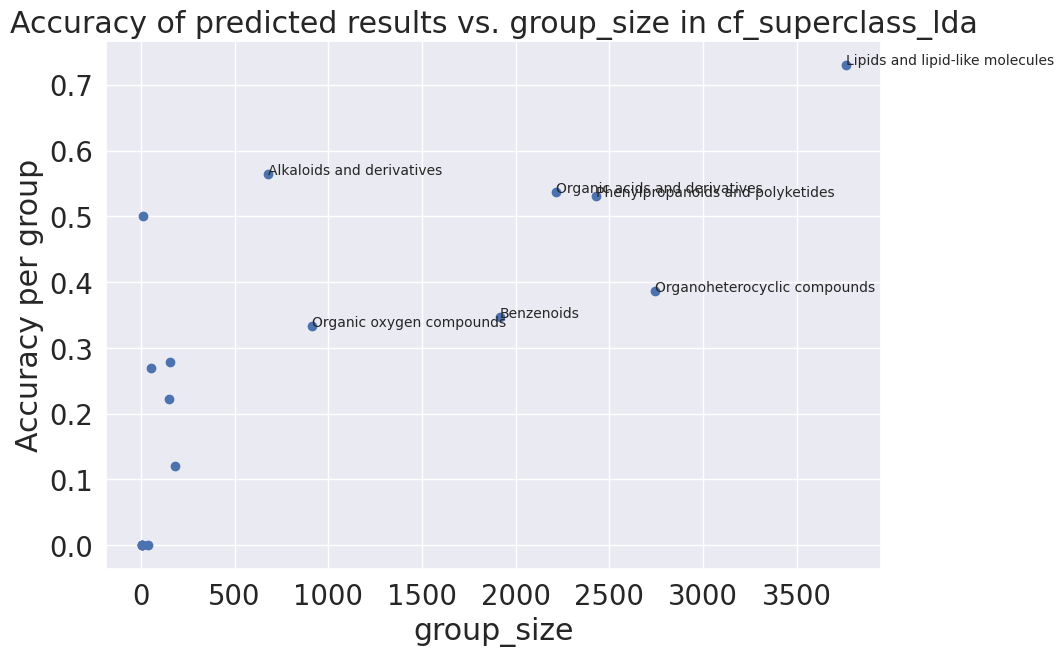

In [42]:
## Loading class labels
data_type='cf_superclass_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_superclass_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Sublass level in ClassyFire

(16360,)
288 groups were selected.
(12552,)
(12552, 300)
Time elapsed: 2.078
Accuracy: 0.334
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


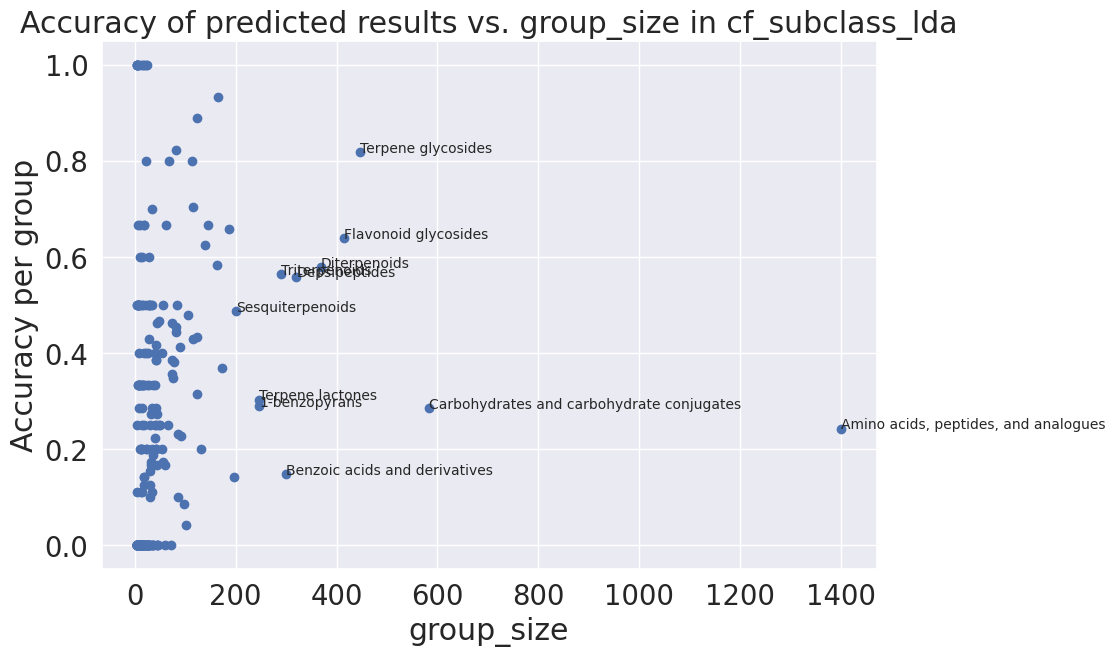

In [43]:
## Loading class labels
data_type='cf_subclass_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_cf_subclass_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_'+data_type+'_min4.svg')

### Class in NPClassifier

(16360,)
309 groups were selected.
(12816,)
(12816, 300)
Selecting 12816 of 16360 spectra.
Time elapsed: 2.071
Accuracy: 0.367
[[0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


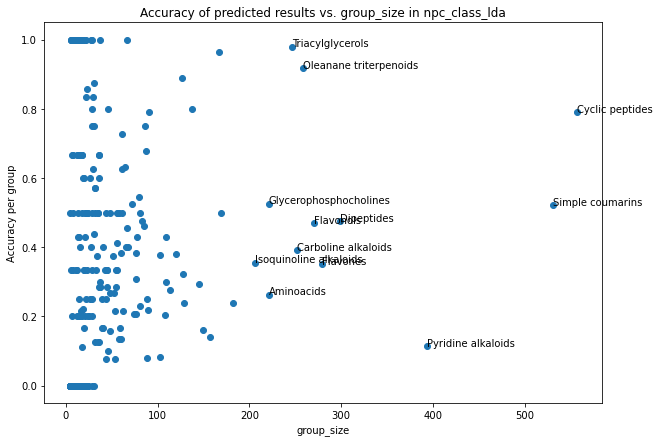

In [34]:
data_type='npc_class_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Superclass in NPClassifier

(16360,)
64 groups were selected.
(13491,)
(13491, 300)
Time elapsed: 1.198
Accuracy: 0.466
[[ 0  0  0 ...  1  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0 19 ...  2  0  1]
 ...
 [ 0  0  4 ... 55  1  1]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  1 ...  0  0  6]]


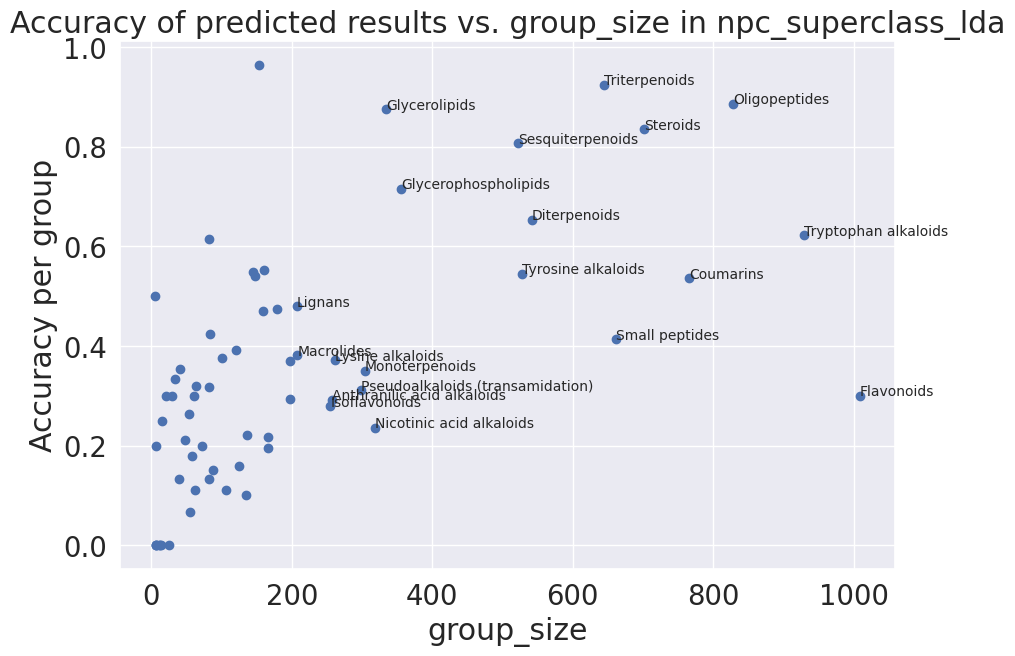

In [45]:
data_type='npc_superclass_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_superclass_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Pathway in NPClassifier

(16360,)
7 groups were selected.
(15268,)
(15268, 300)
Time elapsed: 4.693
Accuracy: 0.621
[[866  26  12  15   8  89  19]
 [149 214  10  14   5  31   9]
 [ 37   1  47   3   1   7   4]
 [103   9   9 209  13  26  24]
 [ 89   7   6  11  61 111  36]
 [171  12   7   8  43 509  18]
 [129  16   7  27  32  91 466]]


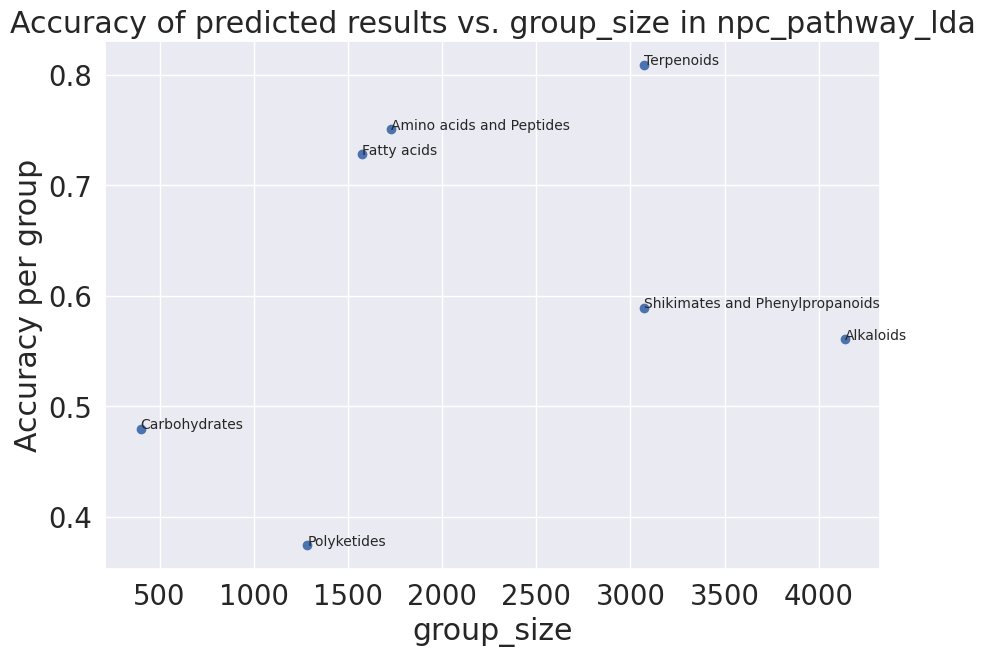

In [46]:
data_type='npc_pathway_lda'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_pathway_results_labels.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
y_label = np.array(y_label_list)
print(y_label.shape)

X_embedding_2, y_label_2 = define_data(X_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

# Redo NPClassifier without muptiple-label spectra

In [35]:
# Define the funtion to kick out multiple-label spectra
def kick_out_multilabel_spectra(x_embeddings, y_labels):
    multi_label_index=[]
    for i,v in enumerate(y_labels):
        lbs = v.split(';')
        if len(lbs) >= 2:
            multi_label_index.append(i)
    print(f'{len(multi_label_index)} multiple-label spectra in {len(y_labels)} spectra.')
    new_embeddings = np.delete(x_embeddings,multi_label_index,0)
    print(new_embeddings.shape)
    new_y_labels = [v for i,v in enumerate(y_labels) if i not in multi_label_index]
    print(f'{len(new_y_labels)} spectra left.')
    return new_embeddings, new_y_labels

### Class in NPClassifier

1501 multiple-label spectra in 16360 spectra.
(14859, 300)
14859 spectra left.
295 groups were selected.
(11324,)
(11324, 300)
Selecting 11324 of 14859 spectra.
Time elapsed: 1.884
Accuracy: 0.369
[[0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


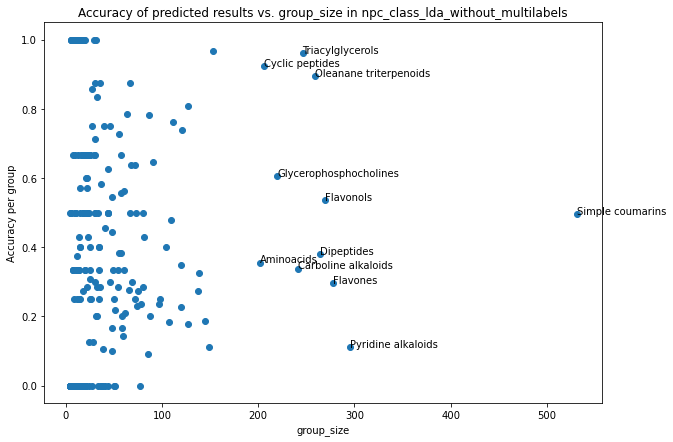

In [37]:
data_type='npc_class_lda_without_multilabels'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels_with_multiple_label.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
new_embedding,y_label_list = kick_out_multilabel_spectra(X_embedding, y_label_list)
X_embedding_2, y_label_2 = define_data(new_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Superclass in NPClassifier

468 multiple-label spectra in 16360 spectra.
(15892, 300)
15892 spectra left.
64 groups were selected.
(13024,)
(13024, 300)
Selecting 13024 of 15892 spectra.
Time elapsed: 1.370
Accuracy: 0.448
[[ 1  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  0 19 ...  1  0  0]
 ...
 [ 0  0  6 ... 64  0  1]
 [ 0  0  1 ...  0  7  0]
 [ 0  0  0 ...  0  0  4]]


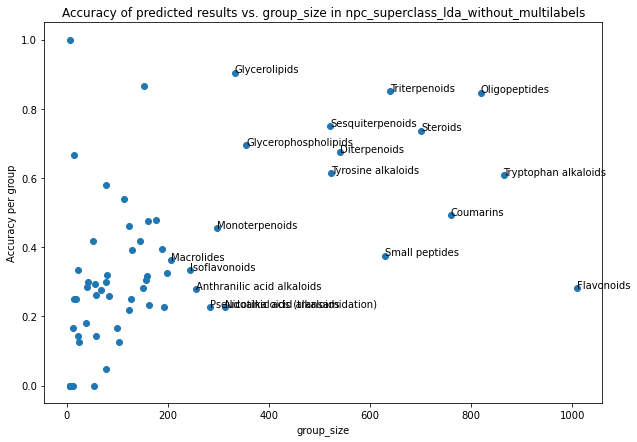

In [38]:
data_type='npc_superclass_lda_without_multilabels'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_superclass_results_labels_with_multiple_label.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
new_embedding,y_label_list = kick_out_multilabel_spectra(X_embedding, y_label_list)
X_embedding_2, y_label_2 = define_data(new_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)

### Pathway in NPClassifier

895 multiple-label spectra in 16360 spectra.
(15465, 300)
15465 spectra left.
7 groups were selected.
(14373,)
(14373, 300)
Selecting 14373 of 15465 spectra.
Time elapsed: 1.097
Accuracy: 0.628
[[778  21  20  11   9 100  13]
 [116 154   8  12   5  20  11]
 [ 33   3  50   1   0  10   3]
 [ 69  10   8 231  10  31  30]
 [ 77  12   8  12  41 112  31]
 [163  12   6   5  24 542  14]
 [110   6  10  40  25 117 460]]


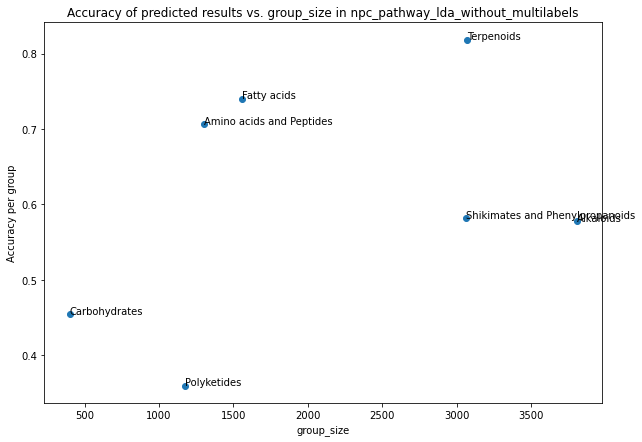

In [39]:
data_type='npc_pathway_lda_without_multilabels'
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_pathway_results_labels_with_multiple_label.pickle', 'rb') as file_name:
    y_label_list = pickle.load(file_name)
new_embedding,y_label_list = kick_out_multilabel_spectra(X_embedding, y_label_list)
X_embedding_2, y_label_2 = define_data(new_embedding, y_label_list, min_group_size=4, remove_unclassified = True)
conf_mat,y_test,y_train,y_pred,labels = perform_lda(X_embedding_2, y_label_2, testing_size = 0.25, stratification=True)
df_cm = plot_confusion_matrix(conf_mat, labels, save_path='/mnt/scratch/ding013/MS2ChemClass/confusion_matrix/heatmap_confusionmatrix_'+data_type+'_min4')
accuracy_dict = calculate_accuracy_per_label(labels, conf_mat, y_train, save_path='/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_'+data_type+'_min4.pickle')
scatter_plot_accuracy_per_label(accuracy_dict,show_annot_min_x=200, x_label='group_size',datatype=data_type, save_dir='/mnt/scratch/ding013/MS2ChemClass/scatter_accuracy_vs_groupsize/dot_accuracy_vs_groupsize_%s_min4.svg' % data_type)